In [421]:
import requests
import datetime
import pandas as pd

# Define the endpoint and parameters
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "inr",
    "days": "365"
}

# Make the request to the CoinGecko API
response = requests.get(url, params=params)
data = response.json()

# Extract the prices, volumes, and market caps
prices = data['prices']
volumes = data['total_volumes']
market_caps = data['market_caps']

# Prepare the data
data_list = []
for i in range(len(prices)):
    timestamp = prices[i][0] / 1000  # Convert milliseconds to seconds
    date = datetime.datetime.fromtimestamp(timestamp).date()
    price_inr = prices[i][1]
    volume = volumes[i][1]
    market_cap = market_caps[i][1]
    data_list.append([date, price_inr, volume, market_cap])

# Create a DataFrame
df = pd.DataFrame(data_list, columns=['Date', 'Price', 'Volume', 'Market Cap'])
# Ensure Date is the index
df.set_index('Date', inplace=True)
print(df)

                   Price        Volume    Market Cap
Date                                                
2023-07-03  2.509846e+06  5.940767e+11  4.873474e+13
2023-07-04  2.551501e+06  1.209178e+12  4.953963e+13
2023-07-05  2.523827e+06  1.017210e+12  4.907725e+13
2023-07-06  2.511781e+06  8.453790e+11  4.880943e+13
2023-07-07  2.482233e+06  1.802426e+12  4.828952e+13
...                  ...           ...           ...
2024-06-27  5.077522e+06  1.914713e+12  1.001469e+14
2024-06-28  5.137474e+06  1.573483e+12  1.013050e+14
2024-06-29  5.028495e+06  2.034122e+12  9.917164e+13
2024-06-30  5.074126e+06  9.533183e+11  1.000239e+14
2024-07-01  5.252034e+06  8.458207e+11  1.032224e+14

[365 rows x 3 columns]


In [422]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Prepare the dataset for the model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        Y.append(data[i + time_step, 0])  # Predicting the price
    return np.array(X), np.array(Y)

# Create the dataset
time_step = 30  # Last 30 days
X, Y = create_dataset(scaled_data, time_step)

# Split the data into training and testing sets
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [423]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=10)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0233
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0019
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0016
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0017


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


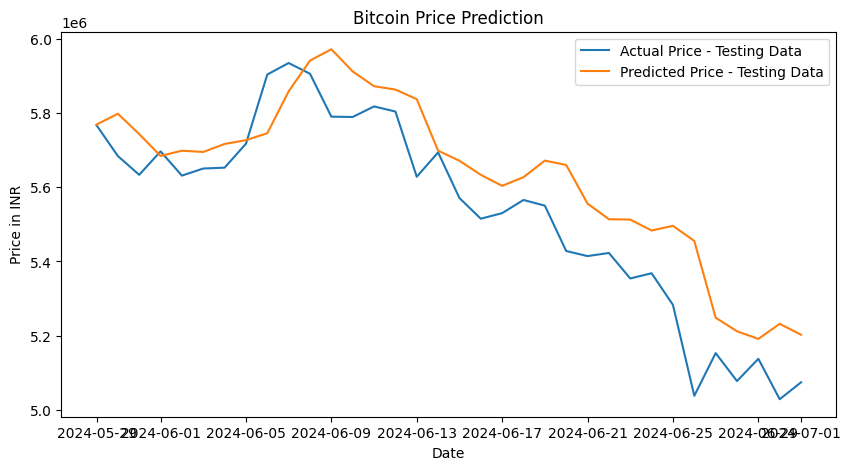

In [424]:
# Evaluate the model
# train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
# train_predict = scaler.inverse_transform(np.concatenate((train_predict, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, X_test[:, -1, 1:]), axis=1))[:, 0]

# Get the actual values
# Y_train_actual = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
Y_test_actual = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# plt.plot(df.index[-len(Y_train_actual):], Y_train_actual, label='Actual Price - Training Data')
plt.plot(df.index[-len(Y_test_actual):], Y_test_actual, label='Actual Price - Testing Data')
# plt.plot(df.index[-len(Y_train_actual):], train_predict, label='Predicted Price - Training Data')
plt.plot(df.index[-len(Y_test_actual):], test_predict, label='Predicted Price - Testing Data')
plt.xlabel('Date')
plt.ylabel('Price in INR')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()


In [425]:
print(test_predict)

[5769110.02444026 5798382.34974656 5743625.89354299 5684661.75203743
 5698721.91323603 5695337.83075322 5716914.99429828 5727153.83715947
 5745853.24112693 5858788.09193503 5941657.77255115 5972391.09969842
 5912445.30691542 5872629.39860685 5863589.87855243 5837589.25097195
 5698816.31643191 5671583.00551677 5633675.74528125 5603960.03253366
 5627350.96775692 5672011.25059081 5660168.26319815 5556022.84678521
 5513911.45024003 5513010.24278865 5483540.59350901 5496110.65112957
 5455315.45753844 5248414.8833065  5211710.0216711  5191190.69443875
 5231814.59000026 5202397.93900603]


In [426]:
print(Y_test_actual)

[5767590.60302967 5684405.44749939 5633683.49066865 5696874.7354901
 5631517.21935621 5650660.766942   5652974.99558827 5717531.99740067
 5904247.37567122 5935197.78299256 5906242.46854217 5790535.80065235
 5789678.95909933 5818062.22031227 5804324.26097417 5628485.11829861
 5694178.80792292 5570966.81851354 5515327.94565987 5530317.82497104
 5565865.27974793 5550495.87692012 5428166.83135806 5414532.84569665
 5422917.84284775 5354170.9760731  5368233.295187   5282950.41854981
 5037773.73743603 5152823.06610879 5077522.43306742 5137474.28820687
 5028494.62999895 5074125.59496904]


In [427]:
price_diff = test_predict[-1]-Y_test_actual[-1]
print(price_diff)

128272.34403699543


[0.02634413 2.00508045 1.95151898 0.21438041 1.19336746 0.79065203
 1.13108582 0.16828659 2.68271508 1.28739924 0.59962496 3.14056083
 2.12043446 0.93789266 1.02105973 3.71510501 0.08144297 1.80608125
 2.14579805 1.33160896 1.10469235 2.18927059 4.27402913 2.61315251
 1.67794553 2.9666454  2.14795617 4.03487097 8.288219   1.85513486
 2.64277687 1.04558005 4.04335641 2.52796943]


Text(0.5, 0, 'No. of Day')

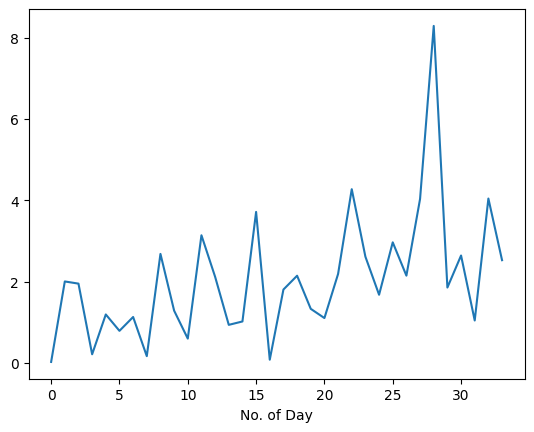

In [428]:
price_diff = []  # Initialize the list outside of the loop

for i in range(0, 34):
    diff = 100*(test_predict[i] - Y_test_actual[i])/Y_test_actual[i] #Calculate the percentage
    price_diff.append(diff)  # Append the difference to the list

# Convert the list to a 1D NumPy array
price_diff_array = abs(np.array(price_diff))
print(price_diff_array)
plt.plot(price_diff_array)
plt.xlabel('No. of Day')

In [429]:
price_diff_array.min()

0.026344127299731356

In [430]:
price_diff_array.max()

8.288219000381803

In [431]:
X_test

array([[[0.80939443, 0.19691019, 0.81150949],
        [0.79916736, 0.16536068, 0.80217769],
        [0.81607244, 0.28147556, 0.82044929],
        ...,
        [0.90899077, 0.28936295, 0.91335114],
        [0.92423476, 0.16204284, 0.92737553],
        [0.90823151, 0.11312615, 0.91174535]],

       [[0.79916736, 0.16536068, 0.80217769],
        [0.81607244, 0.28147556, 0.82044929],
        [0.75271296, 0.41059843, 0.75794037],
        ...,
        [0.92423476, 0.16204284, 0.92737553],
        [0.90823151, 0.11312615, 0.91174535],
        [0.92782212, 0.19413161, 0.93200357]],

       [[0.81607244, 0.28147556, 0.82044929],
        [0.75271296, 0.41059843, 0.75794037],
        [0.69978576, 0.5314779 , 0.70747846],
        ...,
        [0.90823151, 0.11312615, 0.91174535],
        [0.92782212, 0.19413161, 0.93200357],
        [0.90686594, 0.32283108, 0.91249534]],

       ...,

       [[0.90686594, 0.32283108, 0.91249534],
        [0.89408795, 0.25057   , 0.89841361],
        [0.91000723, 0

In [432]:
Y_test

array([0.92782212, 0.90686594, 0.89408795, 0.91000723, 0.89354222,
       0.89836491, 0.89894791, 0.91521125, 0.96224898, 0.97004607,
       0.96275159, 0.93360252, 0.93338666, 0.94053704, 0.93707614,
       0.89277837, 0.90932806, 0.87828824, 0.86427157, 0.86804786,
       0.87700305, 0.87313115, 0.84231376, 0.83887906, 0.84099143,
       0.82367257, 0.82721518, 0.80573054, 0.74396511, 0.77294858,
       0.75397868, 0.76908188, 0.74162749, 0.75312294])

In [433]:
X

array([[[0.1071243 , 0.07043147, 0.10367802],
        [0.11761792, 0.14772962, 0.1139477 ],
        [0.11064638, 0.12360552, 0.1080481 ],
        ...,
        [0.08324939, 0.04625209, 0.0810094 ],
        [0.08151343, 0.07715363, 0.07915998],
        [0.08053211, 0.06442219, 0.07823928]],

       [[0.11761792, 0.14772962, 0.1139477 ],
        [0.11064638, 0.12360552, 0.1080481 ],
        [0.10761163, 0.10201195, 0.10463092],
        ...,
        [0.08151343, 0.07715363, 0.07915998],
        [0.08053211, 0.06442219, 0.07823928],
        [0.08730213, 0.15392708, 0.0830013 ]],

       [[0.11064638, 0.12360552, 0.1080481 ],
        [0.10761163, 0.10201195, 0.10463092],
        [0.10016793, 0.22228156, 0.09799735],
        ...,
        [0.08053211, 0.06442219, 0.07823928],
        [0.08730213, 0.15392708, 0.0830013 ],
        [0.08181797, 0.19591844, 0.07997437]],

       ...,

       [[0.90686594, 0.32283108, 0.91249534],
        [0.89408795, 0.25057   , 0.89841361],
        [0.91000723, 0

In [434]:
last_sequence = scaled_data[-time_step:]
def predict_future(model, data, days_ahead, time_step):
    temp_input = data[-time_step:].reshape(1, time_step, data.shape[1])
    predictions = []
    for _ in range(days_ahead):
        prediction = model.predict(temp_input)
        predictions.append(prediction[0, 0])
        temp_input = np.append(temp_input[:, 1:, :], [[np.append(prediction, temp_input[:, -1, 1:])]], axis=1)
    return predictions


In [435]:
# Predict the next day, week, and month
next_day_prediction = predict_future(model, scaled_data, 1, time_step)
next_week_prediction = predict_future(model, scaled_data, 7, time_step)
next_month_prediction = predict_future(model, scaled_data, 30, time_step)

# Inverse transform to get actual values
next_day_price = scaler.inverse_transform(np.concatenate((np.array(next_day_prediction).reshape(-1, 1), np.zeros((1, 2))), axis=1))[:, 0]
next_week_price = scaler.inverse_transform(np.concatenate((np.array(next_week_prediction).reshape(-1, 1), np.zeros((7, 2))), axis=1))[:, 0]
next_month_price = scaler.inverse_transform(np.concatenate((np.array(next_month_prediction).reshape(-1, 1), np.zeros((30, 2))), axis=1))[:, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━

In [436]:
next_day_price

array([5321961.83428057])

/var/folders/yh/b3ltzp290w726xvdx_kqxdr00000gn/T/ipykernel_24830/2168395850.py:3: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(dates, x, 'g')


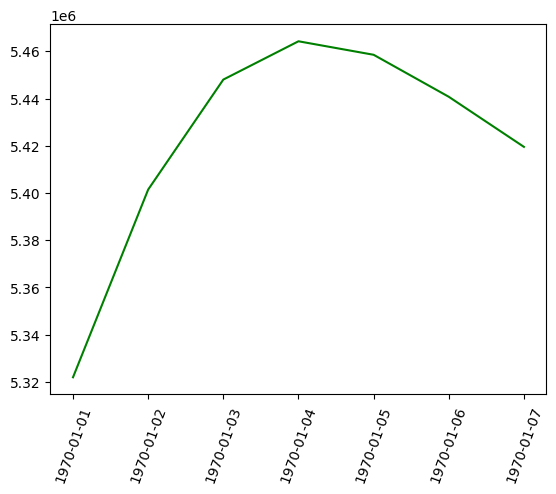

In [449]:
x = next_week_price
dates = pd.date_range(start='2/7/2024',periods=7)
plt.plot_date(dates, x, 'g')
plt.xticks(rotation=70)
plt.show()

/var/folders/yh/b3ltzp290w726xvdx_kqxdr00000gn/T/ipykernel_24830/4194257105.py:3: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(dates, x, 'g')


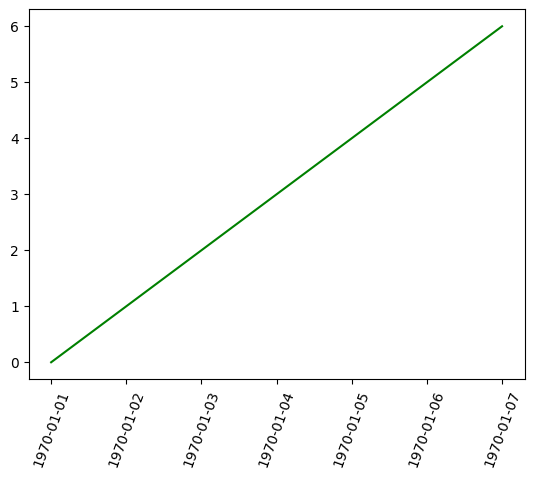

In [442]:
x = [0, 1, 2, 3,4,5,6]
dates = pd.date_range(start=2/7/2024,periods=7)
plt.plot_date(dates, x, 'g')
plt.xticks(rotation=70)
plt.show()

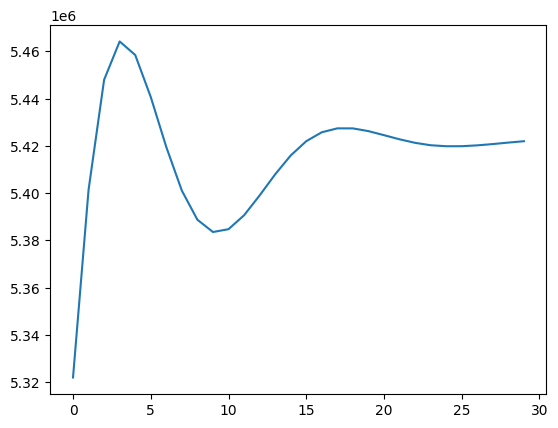

In [438]:
plt.plot(next_month_price)